# Exploratory of product data set
In this section. We aims to look the general and important property of our data. We mainly focus on two parts: first part is the distribution of rantings and the second part is the popularity of the subcategory


## Description of data set

### Time of collection: 12/16-12/19
The data was collected from pinkoi website. The date of collection was from 12/6 15:30 to 12/10 17:00
However, I recolloected the subtag of each product from 12/16 14:30-12/19 08:00 due to some techniques errors.There are mismatch between products on 12/6-12/10 adn 12/16/-12/19. Consequently, I filtered out those mismatch data and **the valid time of data set is 12/16-12/19**

### Field: total 22 fields
* category: Parent category of the product, integer
* discount: The discount of the produc, integer
* free-shipping: Whether the product is free shipping or not, integer, 0 or 1
* irev:I don't know
* locale: Whether the product is local or not, string
* oprice: Original price of the product, integer
* owner: The unique ID of desinger in Pinkoi, string
* price: The price of the product, it equals to oprice-discount, integer
* store_name: The store opened by designer, string
* tid: Unique id of the product in Pinkoi, string
* title: Product name, string
* translated_from_locale: Denote whether the website is translaed version
* \#R1: ratings rated as 1 stars, string
* \#R2: ratings rated as 2 stars, string
* \#R3: ratings rated as 3 stars. string
* \#R4: ratings rated as 4 stars, string
* \#R5: ratings rated as 5 stars, string
* Number of buyers: number of buyers of a prodcut showed on webpage, string
* Product tag: tag of product described by designer, string
* sid, the name of designer
* number of collection: number of collectioner of a prodcut showed on webpage, string
* subcategory: subcatgory of the product, string



In [1]:
import pandas as pd
import numpy as np
from collections import Counter

### Part 1: Overview of Ratings
The first part aims to explore the distribution of ratings to get an overview of ratings, which is a reference of which algorithm of recommendser system to apply. The pre-processing of data in part 1 simply filter out the missing value of ratings

In [2]:
Data=pd.read_csv("input/data_raw.csv",sep=",",encoding='utf8',low_memory=False)

In [3]:
Data.columns

Index([u'category', u'discount', u'free_shipping', u'irev', u'locale',
       u'oprice', u'owner', u'price', u'store_name', u'tid', u'title',
       u'translated_from_locale', u'#R1', u'#R2', u'#R3', u'#R4', u'#R5',
       u'Number of buyers', u'Product Tag', u'SID', u'number of collection',
       u'subcategory'],
      dtype='object')

In [4]:
#Drop duplicate
Data=Data.drop_duplicates(subset=['tid'])

In [5]:
Data=Data[Data.ix[:,'subcategory']!='Missing']

In [6]:
Ratings=Data[['#R1','#R2','#R3','#R4','#R5']]

In [7]:
#The seting in crawler is that once one of rating is missing then all ratings are missing. 
#To filter missing value, we just need to arbitarily choose from #R1~#R5 
Ratings=Ratings[Ratings['#R1']!='Missing']

In [8]:
Ratings.to_csv('Intermediate/ratings.csv',sep=",",encoding='utf8')

In [9]:
def Ratings_sum(r):
    return sum([float(e) for e in r])
    

In [10]:
Ratings.head()

,#R1,#R2,#R3,#R4,#R5
0,0,0,0,0,50
1,0,0,0,4,46
2,0,0,0,1,49
3,0,0,0,3,47
4,0,0,0,3,47


In [11]:
#Take summation of R1,R2,R3,R4,R5 individually
Ratings_list=[]
for i in xrange(5):
    Ratings_list.append(Ratings_sum(Ratings.ix[:,i]))

In [12]:
# A help fuction to lablel y value
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

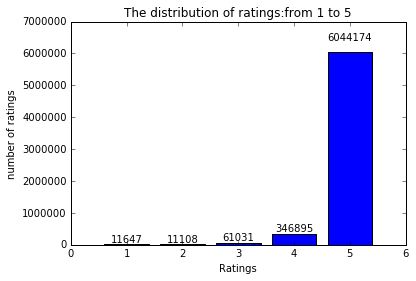

In [14]:
rec=plt.bar(range(1,6),Ratings_list,align='center')
plt.title("The distribution of ratings:from 1 to 5")
plt.xlabel('Ratings')
plt.ylabel('number of ratings')

autolabel(rec)

### Discussion
The percentage of each ratings:<br>
1 stars: $ 0.18\% $<br>
2 stars: $ 0.17\% $<br>
3 stars: $ 0.94\% $<br>
4 stars: $ 5.36\% $<br>
5 stars: $ 93.3\% $<br>

Total number of ratings: $ 6474855 $

As we can see the figure above, the number of ratings are quite skewed! We can infer that most customers are satisfied with out products.(5 stars). For the other ratings, I examined several customer feedback and found out two things:
*  For the customer who gave 1 or 2 stars, the situaion is that the product received has serious defect.
*  The most interesing is 3 stars, some customer gave 3 stars when the product is not 100％ like the pictures. However, some customers rated 3 stars but leave some messages like 很喜歡你們作品、好可愛, which express the emotion like 4 or 5 stars. It also happens when customers rate 4 stars

In conclusion, most customers are satisfied with our products unless the products have serious defect. For 3~4 stars, some customers do have a little bit negative emotion such as 不過好像有點小 while some are still satisfied. It might be result from different scales of rating of the customer or even the contex happened(maybe a phone call interuption) when the customer rated. Hence the number $ 93.3\% $ is just a lower bound 

It might be worthwhile to analyze the emotion scores of messages to compensate with the ratings, but I will introduce a new feature and give deatail discussion about why ratings is a not good proxy of customer preference, especially for EC like Pinkoi in Feature Engineering section

### Part 2 Popularity of Product

This part aims to **determine which subcatgory is the most popular based on *number of purchase, number of collection and the collection-purchase conversion rate***. Though I observed that the number of purchase showed in side bar is not real, I still use it as proxy based on an  asumption that their is a postive correlation between the purchase number showed in side bar and the real one. Rating is not considered as a factor since most customers like our product as mentioned in part 1. I assume the correlation might be low between ratings and popularity

For the calculation of popularity, we use the formula below to estimate it:
$$ p=(a+b)*c $$

where p,a,b,c dentoe popularity, number of purchase,number of collection and collection-purchase conversion rates respectively
I assume that the higher purchase, collection and conversion rate are, the more popular it is.  I don't normalize this value(p) by the number of product in the subcategory. The reason is I assume the more products in one subcategory, the more poppular it is based on rule of demand and supply.

For Missing values, the string 'Missing' is defined in crawler, which happen when crawler cannot retrieve specific data. The value nan might result from some unexpecte errors. We simply replace these values by zero

In [15]:
Popularity_data=Data[['category','subcategory','Number of buyers','number of collection']]

In [16]:
#Filter out the Missing subcategory
Popularity_data=Popularity_data[Popularity_data['subcategory']!='Missing']
Popularity_data=Popularity_data.reset_index(drop=True)

In [17]:
#This step might raise a warning message but we can simply ignore it.
#Parse the number of purchase and collection
Popularity_data['Number of buyers']=[float(e.split(" ")[1]) if e!=u'0' else float(e) for e in Popularity_data['Number of buyers']]
Popularity_data['number of collection']=[float(e.split(" ")[1]) if e!=u'0' else float(e) for e in Popularity_data['number of collection']]

In [18]:
sub_cat=list(set(Popularity_data['subcategory']))

In [19]:
G_purchase=Popularity_data.groupby('subcategory')['Number of buyers'].apply(lambda x:sum(x.tolist()))  #Calculate the sum of purchase for each subcat
G_collection=Popularity_data.groupby('subcategory')['number of collection'].apply(lambda x:sum(x.tolist()))#Calculate the sum of collection for each subcate
Conversion_rate=pd.Series([e[0]/e[1] for e in zip(G_purchase,G_collection)]) #Calculate collection-purchase converiosn rate
normalize=Popularity_data.groupby('subcategory')['number of collection'].apply(lambda x:x.tolist())
Popularity=pd.Series([((e[0]+e[1])*e[2]) for e in zip(G_purchase,G_collection,Conversion_rate)],index=G_purchase.keys()) #Calculate popularity


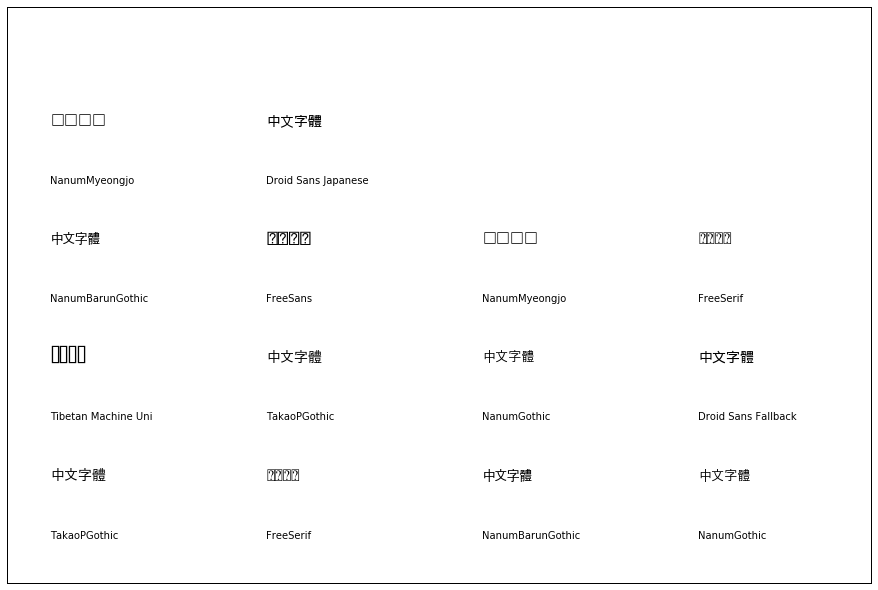

In [20]:
#This piece of code is to fix some font error in matplotlib
from matplotlib.font_manager import fontManager 
import os 
 
fig = plt.figure(figsize=(12,8)) 
ax = fig.add_subplot(111) 
plt.subplots_adjust(0, 0, 1, 1, 0, 0) 
plt.xticks([]) 
plt.yticks([]) 
x, y = 0.05, 0.18 
fonts = [font.name for font in fontManager.ttflist if 
    os.path.exists(font.fname) and os.stat(font.fname).st_size>1e6] 
font = set(fonts) 
dy = (1.0-y)/(len(fonts)/4 + (len(fonts)%4!=0)) 
for font in fonts: 
    t = ax.text(x, y, u"中文字體", {'fontname':font, 'fontsize':14}, transform=ax.transAxes) 
    ax.text(x, y-dy/2, font, transform=ax.transAxes) 
    x += 0.25 
    if x >= 1.0: 
        y += dy 
        x = 0.05 

In [27]:
import matplotlib
matplotlib.rc("font", family="TakaoPGothic")

In [28]:
Popularity.sort(ascending=False)

/home/chenchengkuan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':


In [29]:
pd.DataFrame(Popularity).to_csv("Intermediate/Popularity.csv",sep=",",encoding='utf8')

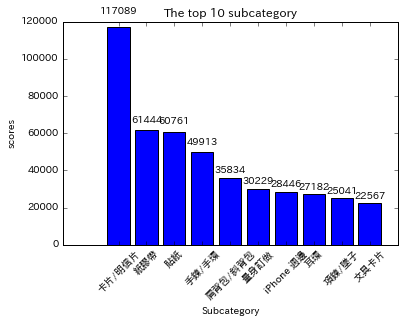

In [30]:
rec=plt.bar(range(10),Popularity[0:10].values,align='center')
plt.title("The top 10 subcategory")
plt.xlabel('Subcategory')
plt.ylabel('scores')
xlb=list(Popularity[0:10].index)
xlb[5]=u'量身訂做'
xlb[9]=u'文具卡片'
plt.xticks(range(10),xlb,rotation=45)

autolabel(rec)

Though the popularity is calculated by a rough estimation, It's still surprising to see that the top 1~10 category mostly contain products that match the taste of normal young lady.,,, Somehow Pinkoi style:)?  

In [31]:
Popularity_data.head()

,category,subcategory,Number of buyers,number of collection
0,3,紙膠帶,49,173
1,10,糖果/軟糖,69,88
2,1,手提包,45,191
3,2,髮飾,124,553
4,2,髮飾,53,319


In [32]:
def PopularityCal(df):
    if df['number of collection']==0:
        df['number of collection']=1.0
    return (df['Number of buyers']+df['number of collection'])*(df['Number of buyers']/df['number of collection'])

In [33]:
Data['Popularity score']=Popularity_data.apply(PopularityCal,axis=1)

In [34]:
Data.head()

,category,discount,free_shipping,irev,locale,oprice,owner,price,store_name,tid,...,#R2,#R3,#R4,#R5,Number of buyers,Product Tag,SID,number of collection,subcategory,Popularity score
0,3,0,0,0,zh_TW,190,yuhuirustudio,190,歪的工作室,1fAYZRbb,...,0,0,0,50,共 49 人購買,紙膠帶,yuhuirustudio,共 173 人收藏,紙膠帶,62.878613
1,10,95,0,1,zh_TW,568,doggysweets,540,DULCET,1Wpbjtdt,...,0,0,4,46,共 69 人購買,"乾果醬,交換禮物,繽紛,聖誕節",DULCET,共 88 人收藏,糖果/軟糖,123.102273
2,1,0,0,0,zh_TW,390,ningoo,390,NING&#39;s,1cf23LXr,...,0,0,1,49,共 45 人購買,手提帶,NING's,共 191 人收藏,手提包,55.602094
3,2,0,0,1,zh_TW,150,mshowfan,150,mshowfan,1XkKaVA0,...,0,0,3,47,共 124 人購買,"好煩小姐,髮帶,點點",Fan,共 553 人收藏,髮飾,151.804702
4,2,0,0,1,zh_TW,180,mshowfan,180,mshowfan,1cDqf1tY,...,0,0,3,47,共 53 人購買,"好煩小姐,復古,手作,混織,髮帶",Fan,共 319 人收藏,髮飾,61.805643


In [35]:
Data.to_csv("Intermediate/data_final.csv",sep=",",encoding='utf8',index=False)